# Analysis of BioImages (in Progress)

This is becoming a collection of Python-based example codes focussing on image analysis of biological matter. Apologies for the code often being a little sloppy and "easy-going". Due to a limited time frame, priorities were set to "progress & visualization" instead of "finding the most efficient solution" :) <br>
Whenever a function or method is developed to fulfill the goals, it is outsources into the subfolder "ModulesOwn", take a look and have fun. Check out my website (www.bio-century.net) for more projects, literature recommendations, links to data bases and further inspirations.

# Table of Contents
0. [Reference Table](#ReferenceTable)
1. [Nuclei Detection on Fluorescence Images](#NucleiDetectionOnFluorescenceImages)
   1. [First Analysis on an Example Micrograph](#FirstAnalysisOnAnExampleMicrograph)
   2. [Statistical Analysis of Automated Nuclei Cell Count](#StatisticalAnalysisOfAutomatedNucleiCellCount)
   3. [Ellipse Fit on Nuclei](#EllipseFitOnNuclei)
2. [First Real Data Analysis](#FirstRealDataAnalysis)
100. [Appendix](#Appendix)
     1.   [.html-Export of Code](#htmlExportOfCode)

# 1. <a name="NucleiDetectionOnFluorescenceImages">Nuclei Detection on Fluorescence Images</a>

## 1.1 <a name="FirstAnalysisOnAnExampleMicrograph">First Analysis on an Example Micrograph</a>

Goal:
Count nuclei of a fluorescence micrograph in an automated way

Steps 1: Import micrograph and compute a binary mask.

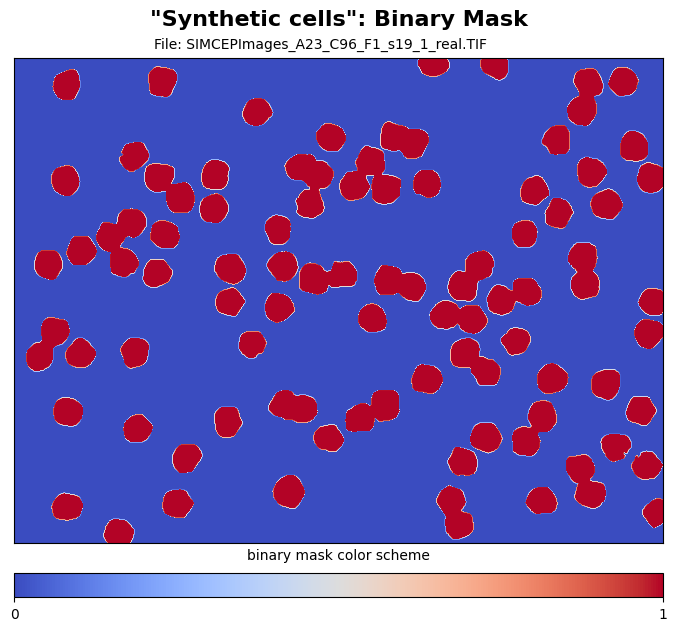

In [1]:
# sources
# - https://bbbc.broadinstitute.org/BBBC005
# - https://bbbc.broadinstitute.org/search/synthetic%20cells?
# - https://www.geeksforgeeks.org/distance-transformation-in-image-python-opencv/
# - https://www.geeksforgeeks.org/how-to-adjust-the-position-of-a-matplotlib-colorbar/
# - https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_watershed/py_watershed.html
# - https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_watershed.html
# - https://stackoverflow.com/questions/70361424/extract-white-regions-from-binary-images
# - https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.binary_fill_holes.html
# - https://www.tutorialspoint.com/how-to-compute-the-area-and-perimeter-of-an-image-contour-using-opencv-python
# - https://www.youtube.com/watch?v=WQpXS9gBEu8


# data source
# Synthetic cells, Accession number BBBC005 · Version 1
# A. Lehmussola, P. Ruusuvuori, J. Selinummi, H. Huttunen and O. Yli-Harja,
# "Computational Framework for Simulating Fluorescence Microscope Images With Cell Populations,"
# in IEEE Transactions on Medical Imaging, vol. 26, no. 7, pp. 1010-1016, July 2007, doi: 10.1109/TMI.2007.896925.
# 
# A. Lehmussola, P. Ruusuvuori, J. Selinummi, T. Rajala and O. Yli-Harja,
# "Synthetic Images of High-Throughput Microscopy for Validation of Image Analysis Methods,"
# in Proceedings of the IEEE, vol. 96, no. 8, pp. 1348-1360, Aug. 2008, doi: 10.1109/JPROC.2008.925490.
# 
# - https://bbbc.broadinstitute.org/BBBC005
# - https://bbbc.broadinstitute.org/search/synthetic%20cells?


# import modules
import cv2
from matplotlib import cm
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from scipy import ndimage

# initialize and define variables and parameter
# fileName           = "SIMCEPImages_A23_C96_F1_s19_w1.TIF"                     # mask
fileName          = "SIMCEPImages_A23_C96_F1_s19_1_real.TIF"                    # "real" image
cellCountTruth     = int(fileName[fileName.find('_C')+2:fileName.find('_F')])   # extract real cell number from filename
myThresholdValue   = 70                                                         # treshold value for binary mask
myImage            = cv2.imread('./ModulesExternal/Data/' + fileName)           # read image
myImageGray        = cv2.cvtColor(myImage, cv2.COLOR_BGR2GRAY)
# ret, thresh        = cv2.threshold(gray, 0, 1, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# fill holes
# define binary mask on computed on thresholded image
myImageThresholded                                = np.zeros(myImageGray.shape)
myImageThresholded[myImageGray > myThresholdValue] = 1
myImageThresholded                                = ndimage.binary_fill_holes(myImageThresholded).astype(int)


# compute and visualize results
fig, ax            = plt.subplots(figsize = (15, 7))
im                 = ax.imshow(myImageThresholded, cmap = cm.coolwarm)
divider            = make_axes_locatable(ax)
cax                = divider.new_vertical(size = "5%", pad = 0.3, pack_start = True)
fig.add_axes(cax)
cbar               = fig.colorbar(im, cax = cax, ticks = [-1, 0, 1], orientation = 'horizontal')
TitleString = "\"Synthetic cells\": Binary Mask\n"
plt.title(TitleString, fontweight="bold", fontsize = 16, y = 22.3)
plt.suptitle("File: " + fileName, fontsize = 10, y = 0.91)
ax.set_xlabel("binary mask color scheme")
ax.set_xticks([])
ax.set_yticks([])
plt.show()

Step 2: Identify single objects and draw contours

---------------------------
     Number of Cells
---------------------------
Detected: 		 74
True Value: 		 96
---------------------------
Merged Cells Delta: 	-22


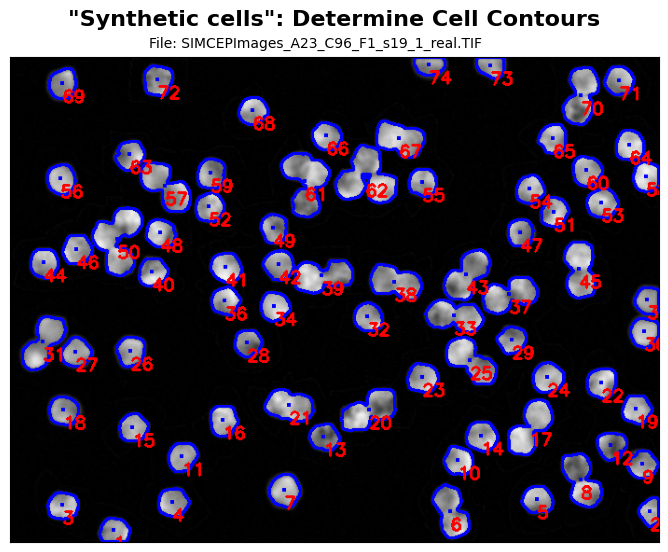

In [2]:
# sources
# - https://www.kaggle.com/code/voglinio/separating-nuclei-masks-using-convexity-defects
# - https://stackoverflow.com/questions/32401806/get-mask-from-contour-with-opencv
# - https://stackoverflow.com/questions/50591442/convert-3-dim-image-array-to-2-dim
# - https://www.tutorialspoint.com/how-to-compute-the-area-and-perimeter-of-an-image-contour-using-opencv-python


# source of main algorithm
# - https://www.kaggle.com/code/voglinio/separating-nuclei-masks-using-convexity-defects
# User: Costas Voglis


# - https://de.mathworks.com/matlabcentral/answers/43435-i-couldn-t-understand-convex-area
# prop.convex_area / prop.filled_area
# convex_area (convex hull): the smallest region that satisfy two conditions: (1) it is convex (2) it contains
# the original region.
# => The ratio increases the less convex the area is (multiple nuclei)


# import modules
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import regionprops
import ModulesOwn.A_Groundwork as Groundwork
from statistics import mean

# initialize and define variables and parameter
# tresholds for
# 1Cell:             single cell
# 2CellCluster:      two cells
# gt2CellCluster:    greater than two cells
dictThresholdValues                 = {}
dictThresholdValues["1Cell"]        = 0
dictThresholdValues["2CellCluster"] = 1.05
dictThresholdValues["gt2CellCluster"] = 1.2


# compute and visualize results
# compute mean area for a single nucleus
meanFilledAreaTmp = Groundwork.meanFilledArea(myImage, myImageThresholded, dictThresholdValues)

# execute main algorith to identify cells and cell cluster
cellCount, contours, myImageContours, myMaskContoursAll = Groundwork.identifyCellContoursAndAreaOverlays(myImage, 
                                                                                                         myImageThresholded, 
                                                                                                         dictThresholdValues,
                                                                                                         meanFilledAreaTmp)

# print table to compare cellcounts
print("-" * 27, end = '\n')
print("     Number of Cells")
print("-" * 27, end = '\n')
print("Detected: \t\t " + str(len(contours)))
print("True Value: \t\t " + str(cellCountTruth))
print("-" * 27, end = '\n')
print("Merged Cells Delta: \t" + str(len(contours) - cellCountTruth))

# plot figure
fig, ax = plt.subplots(figsize = (15, 7))
im      = ax.imshow(myImageContours, cmap = cm.coolwarm)
divider = make_axes_locatable(ax)
cax     = divider.new_vertical(size = "5%",
                           pad = 0.3,
                           pack_start = True)
TitleString = "\"Synthetic cells\": Determine Cell Contours\n"
plt.title(TitleString, fontweight = "bold", fontsize = 16)
plt.suptitle("File: " + fileName, fontsize = 10, y = 0.91)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

Step 3: Identify multi-nuclei regions

---------------------------
     Number of Cells
---------------------------
Detected previously: 	 74
Detected now: 		 96
True Value: 		 96
---------------------------
Merged cells delta: 	 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


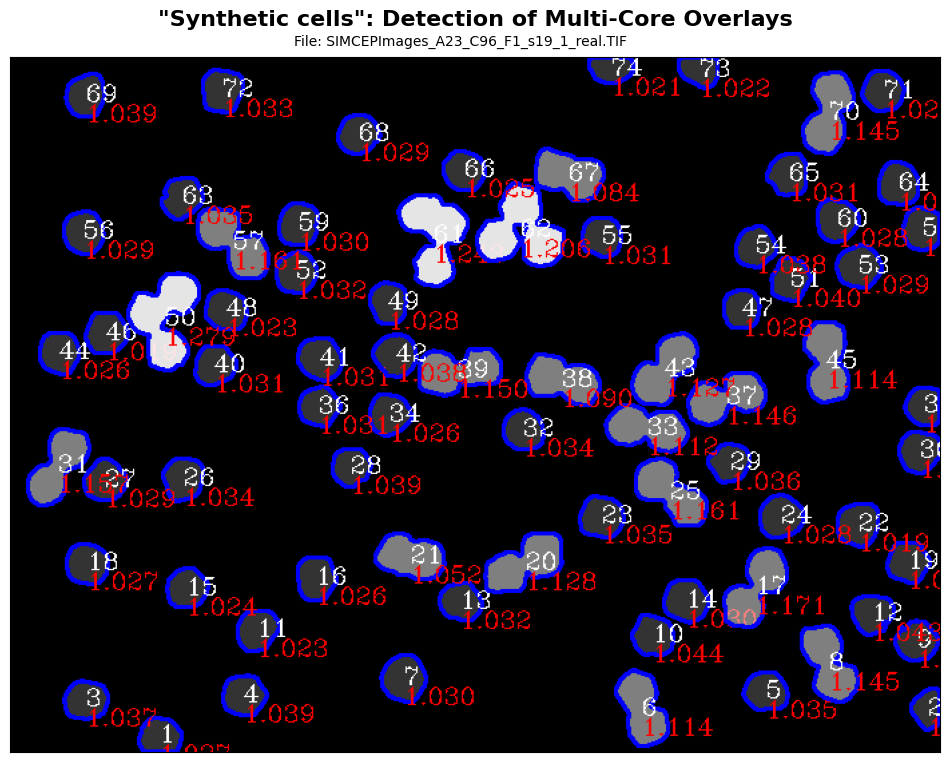

In [3]:
# sources
# - https://www.kaggle.com/code/voglinio/separating-nuclei-masks-using-convexity-defects
# - https://stackoverflow.com/questions/32401806/get-mask-from-contour-with-opencv
# - https://stackoverflow.com/questions/50591442/convert-3-dim-image-array-to-2-dim
# - https://www.tutorialspoint.com/how-to-compute-the-area-and-perimeter-of-an-image-contour-using-opencv-python


# compute and visualize results
# print table to compare cellcounts
print("-" * 27, end = '\n')
print("     Number of Cells")
print("-" * 27, end = '\n')
print("Detected previously: \t " + str(len(contours)))
print("Detected now: \t\t " + str(cellCount))
print("True Value: \t\t " + str(cellCountTruth))
print("-" * 27, end = '\n')
print("Merged cells delta: \t " + str(cellCount - cellCountTruth))

# plot figure
fig, ax = plt.subplots(figsize = (15, 7))
fig.set_figwidth(12)
fig.set_figheight(12)
ax.imshow(myMaskContoursAll)
TitleString = "\"Synthetic cells\": Detection of Multi-Core Overlays\n"
plt.title(TitleString, fontweight="bold", fontsize = 16)
plt.suptitle("File: " + fileName, fontsize = 10, y = 0.803)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

Step 4 (add-on): Compute distance transform

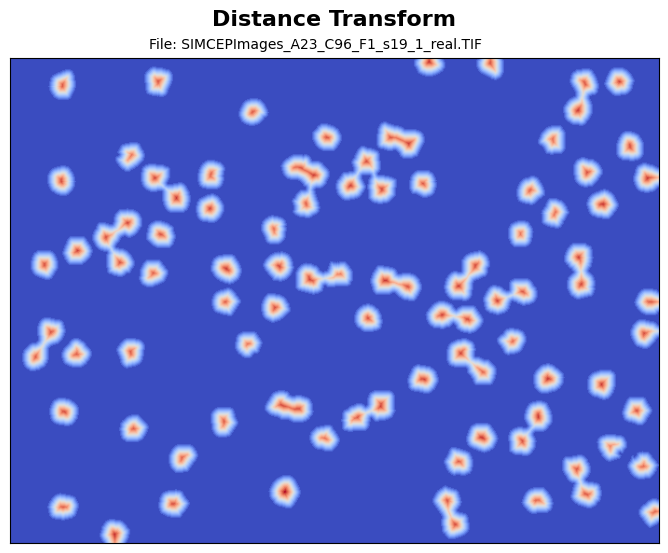

In [4]:
# source
# - https://www.geeksforgeeks.org/distance-transformation-in-image-python-opencv/


# import modules
import cv2
import numpy as np


# compute and visualize results
distTransform = cv2.distanceTransform(myImageThresholded.astype(np.uint8), cv2.DIST_L2, 3)
fig, ax = plt.subplots(figsize = (15, 7))
im      = ax.imshow(distTransform, cmap = cm.coolwarm)
divider = make_axes_locatable(ax)
cax     = divider.new_vertical(size = "5%",
                           pad = 0.3,
                           pack_start = True)

# plot figure
plt.title("Distance Transform", fontweight="bold", fontsize = 16, y = 1.05)
plt.suptitle("File: " + fileName, fontsize = 10, y = 0.91)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

Step 5 (add-on): Compute watershed results and overlay

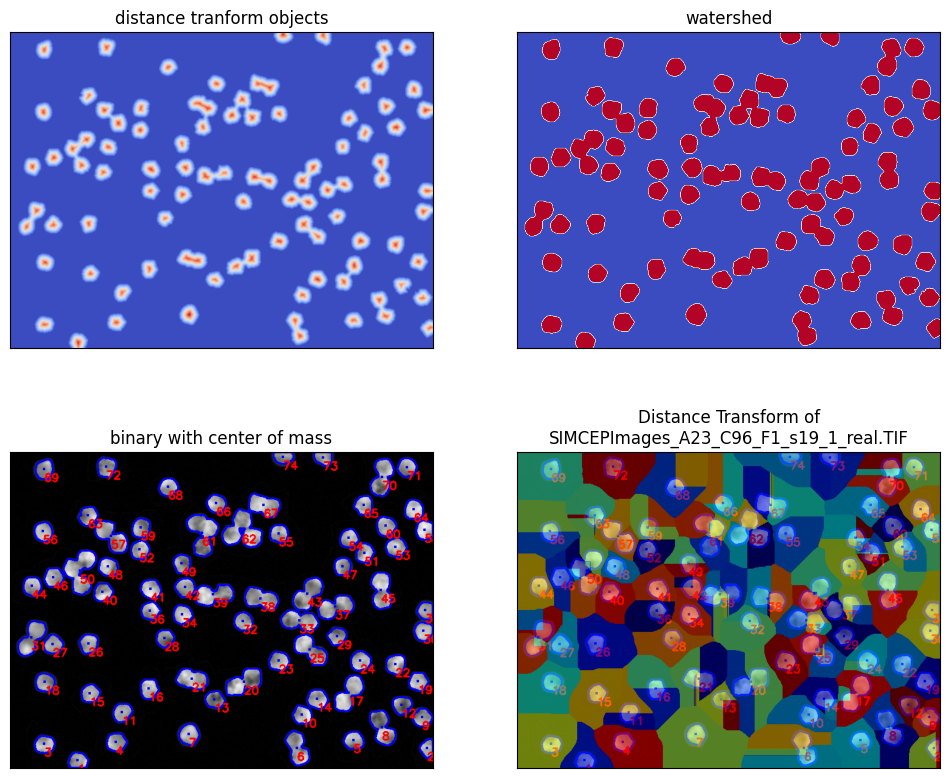

In [5]:
# sources
# - https://www.geeksforgeeks.org/distance-transformation-in-image-python-opencv/
# - https://gist.github.com/jgomezdans/402500
# - https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_watershed.html
# - https://stackoverflow.com/questions/31054352/applying-matplotlib-color-map-to-opencv-image
# - https://stackoverflow.com/questions/40895785/using-opencv-to-overlay-transparent-image-onto-another-image
# - https://stackoverflow.com/questions/60765915/python-opencv-floodfill-function-strange-type-errors
# - https://stackoverflow.com/questions/70251361/imextendedmin-and-imimposemin-functions-in-python-for-watershed-seeds-from-dista


# import modules
import codecs, json
import cv2
from matplotlib import cm
import matplotlib.pyplot as plt 
import numpy as np
from PIL import Image 
from scipy import ndimage
from skimage.segmentation import watershed


# compute and visualize results
distTransform_t = ndimage.distance_transform_edt(myImageThresholded.astype(np.uint8))
# plt.imshow(distTransform_t)
waterShedValues = watershed(- distTransform_t)

cv2.imwrite('./Figures/cellscontourized.png', myImageContours)
cv2.imwrite('./Figures/distTransform.png', distTransform * 255)
cv2.imwrite('./Figures/watershedvalues.png', waterShedValues)

image_array  = plt.imread("./Figures/watershedvalues.png")
randomValues = np.linspace(0,1,256)
np.random.shuffle(randomValues)
cmap = plt.cm.colors.ListedColormap(plt.cm.jet(randomValues))
dictRandomValues = {}
dictRandomValues["randomValues"] = randomValues.tolist()
with open('./ModulesOwn/cmap.json', 'w') as myFile:
    json.dump(dictRandomValues, myFile)
myFile.close()
imageTmp = Image.fromarray(np.uint8(cmap(image_array)*255))
imageTmp.save('./Figures/watershedvaluesRGB.png')
myBackgroundImage = cv2.imread('./Figures/cellscontourized.png')
myOverlayImage    = cv2.imread('./Figures/watershedvaluesRGB.png')
myBackgroundImage = cv2.addWeighted(myBackgroundImage, 0.5, myOverlayImage, 0.5, 0)

# plot figures
fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (12, 10), sharex = True, sharey = True)
ax = axes.ravel()
ax[0].imshow(distTransform, cmap   = cm.coolwarm)
ax[0].set_title('distance tranform objects')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].imshow(myImageThresholded, cmap = cm.coolwarm)
ax[1].set_title('watershed')
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].imshow(myImageContours, cmap = cm.coolwarm)
ax[2].set_title('binary with center of mass')
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[3].imshow(myBackgroundImage, cmap = cm.coolwarm)
ax[3].set_title("Distance Transform of\n" + fileName)
ax[3].set_xticks([])
ax[3].set_yticks([])

plt.show()

## 1.2 <a name="StatisticalAnalysisOfAutomatedNucleiCellCount">Statistical Analysis of Automated Nuclei Cell Count</a>

Goal: Count nuclei of a set of fluorescence micrographs in an automated way and identify the offset on each image by comparison to the ground truth number

------------------------------------------------------------------------------------------------------------------------------------------
                    print scheme: <filename>  <TrueNumberNuclei>  <ComputedNumberNuclei>
------------------------------------------------------------------------------------------------------------------------------------------
SIMCEPImages_A01_C1_F1_s01_w1.TIF: 1  1		SIMCEPImages_A01_C1_F1_s02_w1.TIF: 1  1		SIMCEPImages_A01_C1_F1_s03_w1.TIF: 1  1		
SIMCEPImages_A02_C5_F1_s01_w1.TIF: 5  5		SIMCEPImages_A02_C5_F1_s02_w1.TIF: 5  5		SIMCEPImages_A02_C5_F1_s03_w1.TIF: 5  5		
SIMCEPImages_A03_C10_F1_s01_w1.TIF: 10  10	SIMCEPImages_A03_C10_F1_s02_w1.TIF: 10  10	SIMCEPImages_A03_C10_F1_s03_w1.TIF: 10  9	
SIMCEPImages_A04_C14_F1_s01_w1.TIF: 14  14	SIMCEPImages_A04_C14_F1_s02_w1.TIF: 14  14	SIMCEPImages_A04_C14_F1_s03_w1.TIF: 14  14	
SIMCEPImages_A05_C18_F1_s01_w1.TIF: 18  18	SIMCEPImages_A05_C18_F1_s02_w1.TIF: 18  18	SIMCEPImages_A05_C18_F1_s03_w1.TIF: 18  

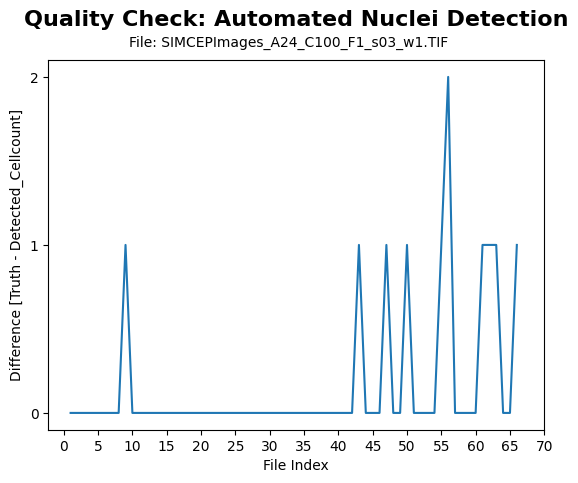

In [6]:
# sources
# - https://www.kaggle.com/code/voglinio/separating-nuclei-masks-using-convexity-defects
# - https://pynative.com/python-list-files-in-a-directory/
# - https://stackoverflow.com/questions/32401806/get-mask-from-contour-with-opencv
# - https://stackoverflow.com/questions/50591442/convert-3-dim-image-array-to-2-dim
# - https://www.tutorialspoint.com/how-to-compute-the-area-and-perimeter-of-an-image-contour-using-opencv-python


# data source
# Synthetic cells, Accession number BBBC005 · Version 1
# A. Lehmussola, P. Ruusuvuori, J. Selinummi, H. Huttunen and O. Yli-Harja,
# "Computational Framework for Simulating Fluorescence Microscope Images With Cell Populations,"
# in IEEE Transactions on Medical Imaging, vol. 26, no. 7, pp. 1010-1016, July 2007, doi: 10.1109/TMI.2007.896925.
# 
# A. Lehmussola, P. Ruusuvuori, J. Selinummi, T. Rajala and O. Yli-Harja,
# "Synthetic Images of High-Throughput Microscopy for Validation of Image Analysis Methods,"
# in Proceedings of the IEEE, vol. 96, no. 8, pp. 1348-1360, Aug. 2008, doi: 10.1109/JPROC.2008.925490.


# import modules
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.measure import regionprops
import ModulesOwn.A_Groundwork as Groundwork
import matplotlib.pyplot as plt
import numpy as np


# initialize and define variables and parameter
xpoints = []
ypoints = []
# tresholds for
# 1Cell:             single cell
# 2CellCluster:      two cells
# gt2CellCluster:    greater than two cells
dictThresholdValues                 = {}
dictThresholdValues["1Cell"]        = 0
dictThresholdValues["2CellCluster"] = 1.05
dictThresholdValues["gt2CellCluster"] = 1.2
myThresholdValue                    = 70
meanFilledAreaAll                   = []
res = []
dir_path = './DataExternalSyntheticCells'


# compute and visualize results
for path in os.listdir(dir_path):
    if os.path.isfile(os.path.join(dir_path, path)):
        res.append(path)

# compute mean area for a single nucleus with all file info
for ii, fileNameTmp in enumerate(res):
    fileName          = fileNameTmp
    cellCountTruth    = int(fileName[fileName.find('_C') + 2 : fileName.find('_F')])
    myImage                                            = cv2.imread('./DataExternalSyntheticCells/' + fileName)
    myImageGray                                        = cv2.cvtColor(myImage, cv2.COLOR_BGR2GRAY)
    myImageThresholded                                 = np.zeros(myImageGray.shape)
    myImageThresholded[myImageGray > myThresholdValue] = 1
    myImageThresholded                                 = ndimage.binary_fill_holes(myImageThresholded).astype(int)
    meanFilledArea = Groundwork.meanFilledArea(myImage, myImageThresholded, dictThresholdValues)
    meanFilledAreaAll.append(meanFilledArea)
meanFilledArea = mean(meanFilledAreaAll) 

# execute main algorith on all files to identify cells and cell cluster
print("-" * 138)
print(" " * 20 + "print scheme: " + "<filename>  <TrueNumberNuclei>  <ComputedNumberNuclei>")
print("-" * 138)
for ii, fileNameTmp in enumerate(res):
    fileName          = fileNameTmp
    cellCountTruth    = int(fileName[fileName.find('_C') + 2 : fileName.find('_F')])
    myImage                                            = cv2.imread('./DataExternalSyntheticCells/' + fileName)
    myImageGray                                        = cv2.cvtColor(myImage, cv2.COLOR_BGR2GRAY)
    myImageThresholded                                 = np.zeros(myImageGray.shape)
    myImageThresholded[myImageGray > myThresholdValue] = 1
    myImageThresholded                                 = ndimage.binary_fill_holes(myImageThresholded).astype(int)

    cellCount, contours, myImageContours, myMaskContoursAll = Groundwork.identifyCellContoursAndAreaOverlays(myImage,
                                                                                                             myImageThresholded,
                                                                                                             dictThresholdValues,
                                                                                                             meanFilledArea)
    if ii < 6:
        print(fileName + ": " + str(cellCountTruth) + "  " + str(cellCount) + "\t\t", end = '')
    else:
        print(fileName + ": " + str(cellCountTruth) + "  " + str(cellCount) + "\t", end = '')
    
    if (ii + 1) % 3 == 0:
        print("\n", end = '')
    
    xpoints.append(ii + 1)
    ypoints.append(cellCountTruth - cellCount)

# plot figure
TitleString = "Quality Check: Automated Nuclei Detection"
x = np.linspace(0, 1, 2)
plt.plot(xpoints, ypoints)
plt.title(TitleString, fontweight="bold", fontsize = 16, y = 1.07)
plt.suptitle("File: " + fileName, fontsize = 10, y = 0.93)
plt.xlabel("File Index")
plt.ylabel("Difference [Truth - Detected_Cellcount]")
plt.xticks(np.arange(0, 72, 5))
plt.yticks(np.arange(0, 3, 1))
plt.show()

## 1.3 <a name="EllipseFitOnNuclei">Ellipse Fit on Nuclei</a>

Goal: Ellipse fit of each nuclei region

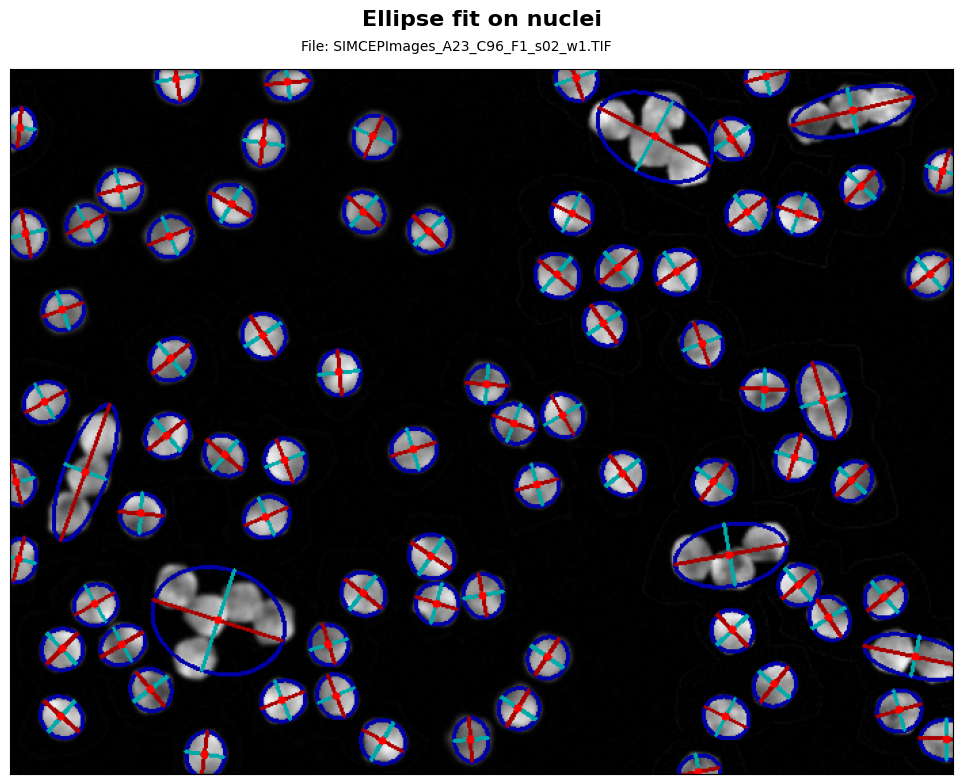

In [7]:
# sources
# - https://www.kaggle.com/code/voglinio/separating-nuclei-masks-using-convexity-defects
# - https://de.mathworks.com/matlabcentral/answers/43435-i-couldn-t-understand-convex-area
# - https://stackoverflow.com/questions/32401806/get-mask-from-contour-with-opencv
# - https://stackoverflow.com/questions/50591442/convert-3-dim-image-array-to-2-dim
# - https://stackoverflow.com/questions/62698756/opencv-calculating-orientation-angle-of-major-and-minor-axis-of-ellipse
# - https://www.tutorialspoint.com/how-to-compute-the-area-and-perimeter-of-an-image-contour-using-opencv-python
# - https://www.tutorialspoint.com/how-to-fit-the-ellipse-to-an-object-in-an-image-using-opencv-python

# sources of main algorithms
# https://www.kaggle.com/code/voglinio/separating-nuclei-masks-using-convexity-defects
# User: Costas Voglis
# and
# https://stackoverflow.com/questions/62698756/opencv-calculating-orientation-angle-of-major-and-minor-axis-of-ellipse
# User: fmw42, Fred Weinhaus


# import modules
import cv2
import numpy as np
import matplotlib.pyplot as plt
import ModulesOwn.A_Groundwork as Groundwork
from skimage.measure import regionprops
import math


fileName           = "SIMCEPImages_A23_C96_F1_s02_w1.TIF"
cellCountTruth     = int(fileName[fileName.find('_C')+2:fileName.find('_F')])
myThresholdValue   = 70

myImage            = cv2.imread('./DataExternalSyntheticCells/' + fileName)
myImageGray        = cv2.cvtColor(myImage, cv2.COLOR_BGR2GRAY)

myImageThresholded                                 = np.zeros(myImageGray.shape)
myImageThresholded[myImageGray > myThresholdValue] = 1
myImageThresholded                                 = ndimage.binary_fill_holes(myImageThresholded).astype(int)

myImageEllipse = Groundwork.ellipseFit(myImage, myImageThresholded)


# plot figure
fig, ax = plt.subplots(figsize = (20, 10))
im      = ax.imshow(myImageEllipse)
divider = make_axes_locatable(ax)
cax     = divider.new_vertical(size = "5%",
                           pad = 0.3,
                           pack_start = True)
plt.title("Ellipse fit on nuclei", fontweight="bold", fontsize = 16, y = 1.05)
plt.suptitle("File: " + fileName, fontsize = 10, y = 0.91)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

## 2.1 <a name="FirstRealDataAnalysis">First Real Data Analysis</a>

Goal:

Analyse a first real fluorescence dataset and see how well the above algorithms work. This is really to play around with data and get a feeling of the algorithms, while there is no explicit scientific question posed here (due to a lack of data).

Plan:
- Step 1: Import fluorescence cell-based micrographs. To this end, we connect to a Image Data Resource-(idr-)-database and directly import a micrograph and its metadata via python
- Step 2: Preprocessing of the data received
- Step 3: Step 3: Preprocessing of data: Set up the masks, exclude debris
- Step 4: Apply ellipse fitting on nuclei and cytoplasm

### Step 1: Import Fluorescence Cell-Based Micrographs and Metadata

### Step 2: Save image

In [ ]:
# import modules
import cv2

# save a image using extension
cv2.imwrite("./DataOwn/02_01_myImageRGB.tif", myImage)
cv2.imwrite("./DataOwn/02_01_myImageR.tif", myImage[:,:,0])
cv2.imwrite("./DataOwn/02_01_myImageG.tif", myImage[:,:,1])
cv2.imwrite("./DataOwn/02_01_myImageB.tif", myImage[:,:,2])

### Step 3: Preprocessing of data: Set up the masks, exclude debris

Import and show data

In [ ]:
# sources
# - https://idr.openmicroscopy.org/
# - https://biapol.github.io/blog/robert_haase/browsing_idr/readme.html
# - https://idr.openmicroscopy.org/webclient/api/plates/
# - https://matplotlib.org/stable/gallery/misc/table_demo.html#sphx-glr-gallery-misc-table-demo-py
# - https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subfigures.html
# - https://stackoverflow.com/questions/31726643/how-to-plot-in-multiple-subplots
# - https://towardsdatascience.com/simple-little-tables-with-matplotlib-9780ef5d0bc4
# - https://towardsdatascience.com/plot-organization-in-matplotlib-your-one-stop-guide-if-you-are-reading-this-it-is-probably-f79c2dcbc801


# data source
# https://idr.openmicroscopy.org/webclient/img_detail/3232695/
# 41744_illum_corrected [Well G9, Field 7]
# "https://idr.openmicroscopy.org/webclient/img_detail/3232695/"
# https://idr.openmicroscopy.org/webclient/api/plates/
# "https://idr.openmicroscopy.org/webclient/img_detail/3232695/"
# https://idr.openmicroscopy.org/webclient/api/plates/
# https://idr.openmicroscopy.org/webclient/img_detail/3232695/
# 41744_illum_corrected [Well G9, Field 7]
# "https://idr.openmicroscopy.org/webclient/img_detail/3232695/"
# https://idr.openmicroscopy.org/webclient/api/plates/


# import modules
import json
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import requests
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np


# initialize and define variables and parameter
screen_id = 1751
imageID = "3232695"
myLink  = "https://idr.openmicroscopy.org/webclient/render_image/" + imageID + "/"
dictImageMetaData = {}
cell_text = []


# load data
################ Import metadata ################
# configure which dataset to browse
# screen_id = 2302
MAP_URL = "https://idr.openmicroscopy.org/webclient/api/annotations/?type=map&{type}={screen_id}"

# open an interface to the internet
with requests.Session() as session:
    # turn the generic MAP_URL into a specific URL for the screen
    qs = {'type': 'screen', 'screen_id': screen_id}
qs = {'image_id': imageID}
IMAGE_DETAILS_URL = "https://idr.openmicroscopy.org/webclient/imgData/{image_id}/"
url = IMAGE_DETAILS_URL.format(**qs)
r = session.get(url)
with open("./DataOwn/02_01_ImageMetaData.json", "w") as outfile:
    if r.status_code == 200:
        json.dump(r.json(), outfile, indent = 4, sort_keys = True)
with open('./DataOwn/02_01_ImageMetaData.json', 'r') as openfile:
    dictImageMetaData = json.load(openfile)


# compute and visualize results
################ Import image ################
myImage = imread(myLink)

# table 1: file imformation
tableColumnsFileInfo =  ["File Info"]
tableRowsFileInfo    =  ['myLink', 'MAP_URL', 'IMAGE_DETAILS_URL', 'imageId', 'tiles', 'wellId', 'height', 'width']
tableDataFileInfo    =  [
                            [str(myLink)],
                            [str(MAP_URL)],
                            [str(url)],
                            [str(dictImageMetaData["meta"]['imageId'])],
                            [str(dictImageMetaData["tiles"])],
                            [str(dictImageMetaData["meta"]['wellId'])],
                            [str(dictImageMetaData["size"]['height'])],
                            [str(dictImageMetaData["size"]['width'])],
                        ]
cell_text0 = []
for row in range(len(tableDataFileInfo)):
    cell_text0.append(tableDataFileInfo[row])

# table 2: channel information
tableColumnsChannelInfo =   ['label', 'active status', 'hexacode']
tableRowsChannelInfo    =   ['Red Channel','Green Channel','Blue Channel','Blue Channel','Blue Channel']
tableDataChannelInfo    =   [
                            [str(dictImageMetaData["channels"][0]['label']), str(dictImageMetaData["channels"][0]['active']), str(dictImageMetaData["channels"][0]['color'])],
                            [str(dictImageMetaData["channels"][1]['label']), str(dictImageMetaData["channels"][1]['active']), str(dictImageMetaData["channels"][1]['color'])],
                            [str(dictImageMetaData["channels"][2]['label']), str(dictImageMetaData["channels"][2]['active']), str(dictImageMetaData["channels"][2]['color'])],
                            [str(dictImageMetaData["channels"][3]['label']), str(dictImageMetaData["channels"][3]['active']), str(dictImageMetaData["channels"][3]['color'])],
                            [str(dictImageMetaData["channels"][4]['label']), str(dictImageMetaData["channels"][4]['active']), str(dictImageMetaData["channels"][4]['color'])],
                            ]

# there is no pixel size available for this micrograph!
cell_text = []
for row in range(len(tableDataChannelInfo)):
    cell_text.append(tableDataChannelInfo[row])
rowColors =  [
            [0.54901961, 0.58559016, 0.77517878, 1. ],
            [0.54901961, 0.58559016, 0.77517878, 1. ],
            [0.54901961, 0.58559016, 0.77517878, 1. ],
            [0.54901961, 0.58559016, 0.77517878, 1. ],
            [0.54901961, 0.58559016, 0.77517878, 1. ],
            ]
colColors =  [
            [0.54901961, 0.58559016, 0.77517878, 1. ],
            [0.54901961, 0.58559016, 0.77517878, 1. ],
            [0.54901961, 0.58559016, 0.77517878, 1. ],
            ]
colColors0 =  [
            [0.54901961, 0.58559016, 0.77517878, 1. ],
            [0.54901961, 0.58559016, 0.77517878, 1. ],
            [0.54901961, 0.58559016, 0.77517878, 1. ],
            ]
rowColors0 =  [
            [0.54901961, 0.58559016, 0.77517878, 1. ],
            [0.54901961, 0.58559016, 0.77517878, 1. ],
            [0.54901961, 0.58559016, 0.77517878, 1. ],
            [0.54901961, 0.58559016, 0.77517878, 1. ],
            [0.54901961, 0.58559016, 0.77517878, 1. ],
            [0.54901961, 0.58559016, 0.77517878, 1. ],
            [0.54901961, 0.58559016, 0.77517878, 1. ],
            [0.54901961, 0.58559016, 0.77517878, 1. ],
            ]

################ show figure ################
# set up figure grid
fig = plt.figure(figsize = (20, 10))
gs = GridSpec(nrows = 1, ncols = 1)

# plot image
ax0 = fig.add_subplot(gs[0, 0])
ax0.imshow(myImage)
# ax0 = plt.gca()
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)# Hide axes border

plt.suptitle("Ellipse fit on nuclei", fontweight = "bold", fontsize = 16, y = 0.95)# Add footer
plt.draw()# Create image. plt.savefig ignores figure edge and face colors, so map them.
plt.show()


fig = plt.figure(figsize = (10, 4.5))
gs = GridSpec(nrows = 2, ncols = 1)
ax1 = fig.add_subplot(gs[0, 0])
the_table = plt.table(cellText   = cell_text0,
                      rowLabels  = tableRowsFileInfo,
                      rowColours = rowColors0,
                      colLabels  = tableColumnsFileInfo,
                      colColours = colColors0,
                      loc        = 'center')
the_table.scale(0.9, 1.4)
ax1 = plt.gca()
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
plt.box(on=None)# Add title


ax2 = fig.add_subplot(gs[1, 0])
the_table = plt.table(cellText   = cell_text,
                      rowLabels  = tableRowsChannelInfo,
                      rowColours = rowColors,
                      colLabels  = tableColumnsChannelInfo,
                      colColours = colColors,
                      loc        = 'center')
the_table.scale(0.9, 1.4)
ax2 = plt.gca()
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
plt.box(on=None)# Add title


fig = plt.figure(figsize = (20, 7))
gs = GridSpec(nrows = 1, ncols = 3)

ax3 = fig.add_subplot(gs[0, 0])
plt.imshow(myImage[:,:,0])
ax3 = plt.gca()
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)

ax4 = fig.add_subplot(gs[0, 1])
plt.imshow(myImage[:,:,1])
ax4 = plt.gca()
ax4.get_xaxis().set_visible(False)
ax4.get_yaxis().set_visible(False)

ax5 = fig.add_subplot(gs[0, 2])
plt.imshow(myImage[:,:,2])
ax5 = plt.gca()
ax5.get_xaxis().set_visible(False)
ax5.get_yaxis().set_visible(False)

Define nuclei mask

In [ ]:
# sources
# import modules
# import modules
import cv2
from matplotlib import cm
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from scipy import ndimage

# define filenames and parameters
fileName          = "02_01_myImageR.tif"
myThresholdValue   = 30

myImage            = cv2.imread('./DataOwn/' + fileName)
myImageGray        = cv2.cvtColor(myImage, cv2.COLOR_BGR2GRAY)
# ret, thresh        = cv2.threshold(gray, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# fill holes

# define binary mask on computed on thresholded image
myImageThresholded                                = np.zeros(myImageGray.shape)
myImageThresholded[myImageGray > myThresholdValue] = 1
myImageThresholded                                = ndimage.binary_fill_holes(myImageThresholded).astype(int)

# plot figure
fig = plt.figure(figsize = (20, 10))
gs = GridSpec(nrows = 1, ncols = 3)

ax0 = fig.add_subplot(gs[0, 0])
plt.imshow(myImage[:,:,0])
ax0 = plt.gca()
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)

ax1 = fig.add_subplot(gs[0, 1])
plt.imshow(myImageThresholded)
ax1 = plt.gca()
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

Remove small objects from nuclei mask

In [ ]:
from skimage import morphology

# sources
# https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects

# remove small objects
minimum_pixelarea                              = 30
myImageThresholdedtmp                          = []
myImageThresholdedrso                          = []
myImageThresholdedtmp                          = myImageThresholded
myImageThresholdedtmp[980+20:1030, 550:585]    = 0
myImageThresholdedtmp[980:1025, 550+25:585+20] = 0
myImageThresholdedtmp[990+2:1010, 550:585+20]  = 0
myImageThresholdedrso = morphology.remove_small_objects(np.array(myImageThresholdedtmp, dtype=bool), minimum_pixelarea)
myImageRThresholdedRSO = myImageThresholdedrso


# plot figure
fig, ax            = plt.subplots(figsize = (15, 7))
im                 = ax.imshow(myImageThresholdedrso, cmap = cm.coolwarm)
divider            = make_axes_locatable(ax)
cax                = divider.new_vertical(size = "5%", pad = 0.3, pack_start = True)
fig.add_axes(cax)
cbar               = fig.colorbar(im, cax = cax, ticks = [-1, 0, 1], orientation = 'horizontal')
TitleString = "\"Synthetic cells\": Binary Mask\n"
plt.title(TitleString, fontweight="bold", fontsize = 16, y = 22.3)
plt.suptitle("File: " + fileName, fontsize = 10, y = 0.91)
ax.set_xlabel("binary mask color scheme")
# ax.set_xticks([])
# ax.set_yticks([])
plt.show()



Define mask for cytoplasm and mask out debris

In [ ]:
# sources
# https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects


# import modules
from skimage import morphology


# define filenames and parameters
fileName          = "02_01_myImageG.tif"
myThresholdValue   = 10

myImage            = cv2.imread('./DataOwn/' + fileName)
myImageGray        = cv2.cvtColor(myImage, cv2.COLOR_BGR2GRAY)
# ret, thresh        = cv2.threshold(gray, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# fill holes

# define binary mask on computed on thresholded image
myImageThresholded                                = np.zeros(myImageGray.shape)
myImageThresholded[myImageGray > myThresholdValue] = 1
myImageThresholded                                = ndimage.binary_fill_holes(myImageThresholded).astype(int)

# remove small objects
minimum_pixelarea                              = 30
myImageThresholdedtmp                          = []
myImageThresholdedrso                          = []
myImageThresholdedtmp                          = myImageThresholded

# remove specific debris
myImageThresholdedtmp[980+20:1030, 550:585]    = 0
myImageThresholdedtmp[980:1025, 550+25:585 + 20] = 0
myImageThresholdedtmp[990+2:1010, 550:585 + 20]  = 0
myImageThresholdedrso = morphology.remove_small_objects(np.array(myImageThresholdedtmp, dtype=bool), minimum_pixelarea)
myImageGThresholdedRSO = myImageThresholdedrso


# plot figure
fig = plt.figure(figsize = (20, 10))
gs = GridSpec(nrows = 1, ncols = 3)

ax0 = fig.add_subplot(gs[0, 0])
plt.imshow(myImage[:,:,0])
ax0 = plt.gca()
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)

ax1 = fig.add_subplot(gs[0, 1])
plt.imshow(myImageThresholdedrso)
ax1 = plt.gca()
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

Review masks

In [ ]:
contours, myImageContours, myMaskRContoursAll, myMaskRContoursAllLabel = Groundwork.identifyCellContours(myImage, myImageRThresholdedRSO, showCenterOfMass=False, perimeterColor=[20, 240, 20])
contours, myImageContours, myMaskGContoursAll, myMaskGContoursAllLabel = Groundwork.identifyCellContours(myImage, myImageGThresholdedRSO, showCenterOfMass=False, perimeterColor=[20, 240, 20])


fig = plt.figure(figsize = (16, 15))
gs = GridSpec(nrows = 1, ncols = 3)
ax0 = fig.add_subplot(gs[0, 0])
plt.imshow(myImageContours)
ax0 = plt.gca()
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)

myMaskContoursAll   = np.zeros(myImage.shape)
myMaskContoursAll[myMaskGContoursAll==1] = 100
myMaskContoursAll[myMaskRContoursAll==1] = 255

print(np.min(myMaskGContoursAllLabel))
print(np.max(myMaskGContoursAllLabel))

ax1 = fig.add_subplot(gs[0, 1])
plt.imshow(myMaskContoursAll.astype(np.uint8))
ax1 = plt.gca()
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

ax2 = fig.add_subplot(gs[0, 2])
plt.imshow(myMaskGContoursAllLabel.astype(np.uint8))
ax2 = plt.gca()
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

Eliminate everything without a nucleus from cytoplasmic mask

In [ ]:
import math


plotstatus = False
jj=0
myMaskContoursAllCorrected   = np.zeros((myImage.shape[0], myImage.shape[1],int(np.max(myMaskGContoursAllLabel))))
print(myMaskContoursAllCorrected.shape)

for ii in range(1,int(np.max(myMaskGContoursAllLabel))+1):
    myMaskTmp = np.zeros((myImage.shape[0], myImage.shape[1]))
    myMaskTmp[myMaskGContoursAllLabel==ii]=1
    if np.max(myImageRThresholdedRSO + myMaskTmp) > 1:
        print(ii, ",", end='')
        myMaskContoursAllCorrected[:,:,ii-1] = myMaskTmp


if plotstatus==True:
    f, axarr = plt.subplots(20,5,figsize = (20, 100))
    for ii in range(int(np.max(myMaskGContoursAllLabel))):
        xindex = ii % 5
        yindex = math.floor(ii/5)
        axarr[yindex,xindex].imshow(myMaskContoursAllCorrected[:,:,ii])
        axarr[yindex,xindex].set_title(ii)

Review masks

In [ ]:
fig = plt.figure(figsize = (16, 15))
gs = GridSpec(nrows = 2, ncols = 2)
result= np.sum(myMaskContoursAllCorrected[:,:,1:], axis = 2)
ax0 = fig.add_subplot(gs[0, 0])
plt.imshow(myImageContours)
ax0 = plt.gca()
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)

myMaskContoursAll   = np.zeros(myImage.shape)
myMaskContoursAll[myMaskGContoursAll==1] = 100
myMaskContoursAll[myMaskRContoursAll==1] = 255

ax1 = fig.add_subplot(gs[0, 1])
plt.imshow(myMaskContoursAll.astype(np.uint8))
ax1 = plt.gca()
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

ax2 = fig.add_subplot(gs[1, 0])
plt.imshow(myMaskGContoursAllLabel.astype(np.uint8))
ax2 = plt.gca()
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)


ax3 = fig.add_subplot(gs[1, 1])
plt.imshow(result)
ax3 = plt.gca()
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)

Ellipse fit on nuclei and whole cell

In [ ]:
# sources
# https://www.kaggle.com/code/voglinio/separating-nuclei-masks-using-convexity-defects
# https://de.mathworks.com/matlabcentral/answers/43435-i-couldn-t-understand-convex-area
# https://stackoverflow.com/questions/32401806/get-mask-from-contour-with-opencv
# https://stackoverflow.com/questions/50591442/convert-3-dim-image-array-to-2-dim
# https://stackoverflow.com/questions/62698756/opencv-calculating-orientation-angle-of-major-and-minor-axis-of-ellipse
# https://www.tutorialspoint.com/how-to-compute-the-area-and-perimeter-of-an-image-contour-using-opencv-python
# https://www.tutorialspoint.com/how-to-fit-the-ellipse-to-an-object-in-an-image-using-opencv-python

# sources of main algorithms
# https://www.kaggle.com/code/voglinio/separating-nuclei-masks-using-convexity-defects
# User: Costas Voglis
# and
# https://stackoverflow.com/questions/62698756/opencv-calculating-orientation-angle-of-major-and-minor-axis-of-ellipse
# User: fmw42, Fred Weinhaus

# import modules
import cv2
import numpy as np
import matplotlib.pyplot as plt
import ModulesOwn.A_Groundwork as Groundwork
from skimage.measure import regionprops
import math


fileName = "02_01_myImageRGB.tif"
myImage            = cv2.imread('./DataOwn/' + fileName)


myImageEllipse = Groundwork.ellipseFit(myMaskContoursAll.astype(np.uint8), result)
myImageEllipseR = Groundwork.ellipseFit(myMaskContoursAll.astype(np.uint8), myImageRThresholdedRSO)


fig = plt.figure(figsize = (16, 15))
gs = GridSpec(nrows = 1, ncols = 2)

ax0 = fig.add_subplot(gs[0, 0])
plt.imshow(myImageEllipseR)
ax0 = plt.gca()
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)

ax1 = fig.add_subplot(gs[0, 1])
plt.imshow(myImageEllipse)
ax1 = plt.gca()
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

# 100. <a name="Appendix">Appendix</a>

## 100.1 <a name="htmlExportOfCode">.html-Export of Code</a>

In [8]:
# export code to html
import os
os.system("jupyter nbconvert AnalysisOfBioImages.ipynb --to html")

0